In this project, we are working as data scientists for an NBA team, analyzing player data from the 2023-2024 regular season to identify new player archetypes that reflect the evolving roles in modern basketball. Instead of using the traditional positions like Point Guard or Center, we came up with five distinct character tropes based on player behaviors and performance statistics. These archetypes include the Risk Taker, who attempts the most 2-pointers, 3-pointers, and steals; the MVP, representing the player who scores the most points (the "King" of scoring); the BFF, focused on players with the most assists, blocks, personal fouls, and turnovers; the Marathon Runner, players who spend the most time in games; and finally, players who rank highly in each of these categories. Our goal is to use these archetypes as flexible, data-driven representations of player behavior in today's game.

## Imports:

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

## Reading data:

In [8]:
import os
root_dir = os.getcwd()  
file_path = os.path.join(root_dir, '2023-2024 NBA Player Stats - Playoffs.csv')

In [9]:
# Read the data with semicolon separator
data = pd.read_csv(file_path, sep=';')

data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\betak\\NBA-Archetypes\\2023-2024 NBA Player Stats - Playoffs.csv'

## Checking for missing values and/or duplicates:

In [ ]:
duplicates = data.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

missing_values = data.isna().sum()
print("Missing values in each column:")
print(missing_values)

Number of duplicates: 0
Missing values in each column:
Rk        0
Player    0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64


Rk : Rank

Player : Player's name

Pos : Position

Age : Player's age

Tm : Team

G : Games played

GS : Games started

MP : Minutes played per game

FG : Field goals per game

FGA : Field goal attempts per game

FG% : Field goal percentage

3P : 3-point field goals per game

3PA : 3-point field goal attempts per game

3P% : 3-point field goal percentage

2P : 2-point field goals per game

2PA : 2-point field goal attempts per game

2P% : 2-point field goal percentage

eFG% : Effective field goal percentage

FT : Free throws per game

FTA : Free throw attempts per game

FT% : Free throw percentage

ORB : Offensive rebounds per game

DRB : Defensive rebounds per game

TRB : Total rebounds per game

AST : Assists per game

STL : Steals per game

BLK : Blocks per game

TOV : Turnovers per game

PF : Personal fouls per game

PTS : Points per game

In [5]:
columns_to_drop = [
    'Rk', 'Player', 'Pos', 'Tm',   # Descriptive columns
    'FG%', '3P%', '2P%', 'eFG%', 'FT%',  # Percentage columns
    'TRB'  # Totals column
]

# Drop the columns
filtered_data = data.drop(columns=columns_to_drop)

# Save or display the filtered dataset
print(filtered_data.head())  # Display the first few rows

NameError: name 'data' is not defined

## EDA:

               Rk        Age           G          GS          MP          FG  \
count  214.000000  214.00000  214.000000  214.000000  214.000000  214.000000   
mean   107.500000   26.88785    7.873832    3.831776   19.960280    3.101402   
std     61.920648    4.55705    5.471906    5.827708   13.423708    3.023468   
min      1.000000   19.00000    1.000000    0.000000    1.000000    0.000000   
25%     54.250000   23.00000    4.000000    0.000000    6.100000    0.700000   
50%    107.500000   26.00000    6.000000    0.000000   18.850000    2.000000   
75%    160.750000   30.00000   11.750000    6.000000   33.525000    4.775000   
max    214.000000   39.00000   22.000000   22.000000   44.500000   11.800000   

              FGA         FG%          3P         3PA  ...         FT%  \
count  214.000000  214.000000  214.000000  214.000000  ...  214.000000   
mean     6.843925    0.407477    0.920561    2.700935  ...    0.581682   
std      6.174591    0.185326    0.964169    2.492373  ..

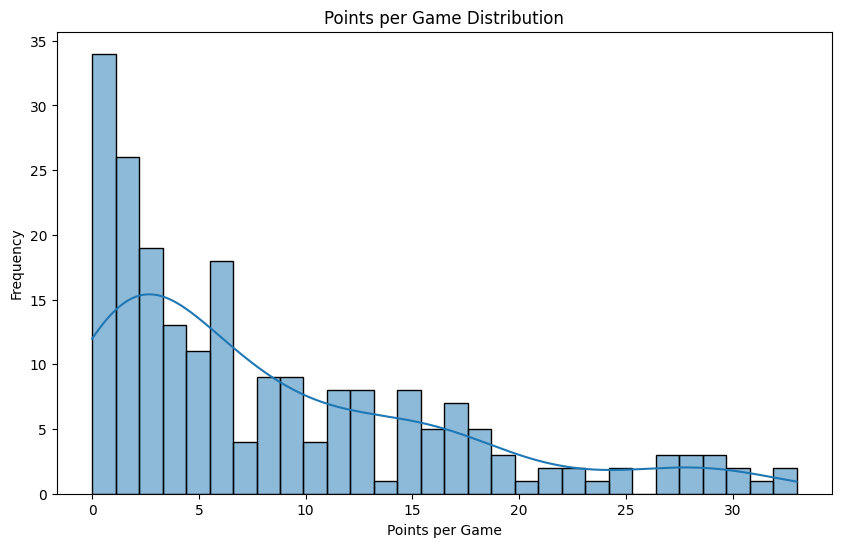

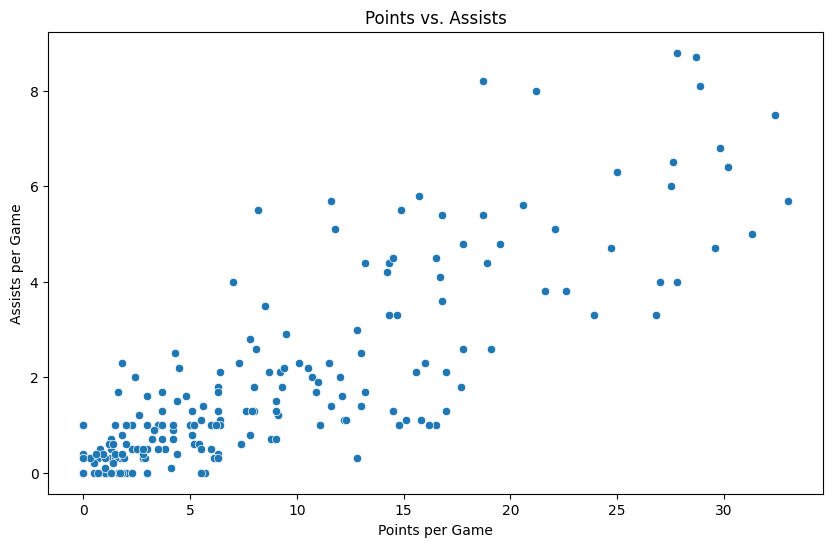

C:\Users\betak\AppData\Local\Temp\ipykernel_20868\1332594037.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


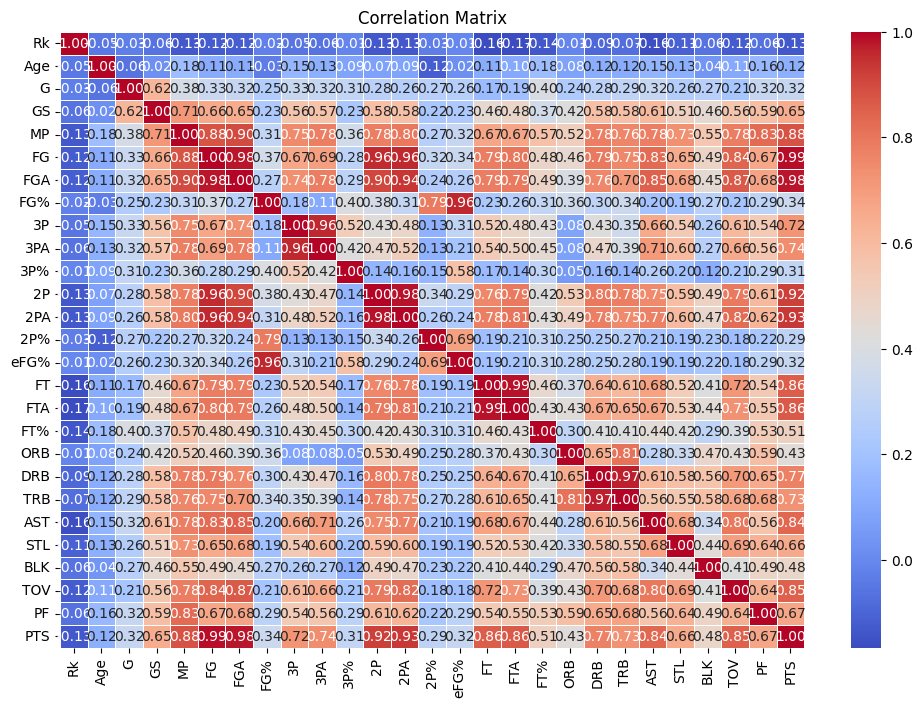

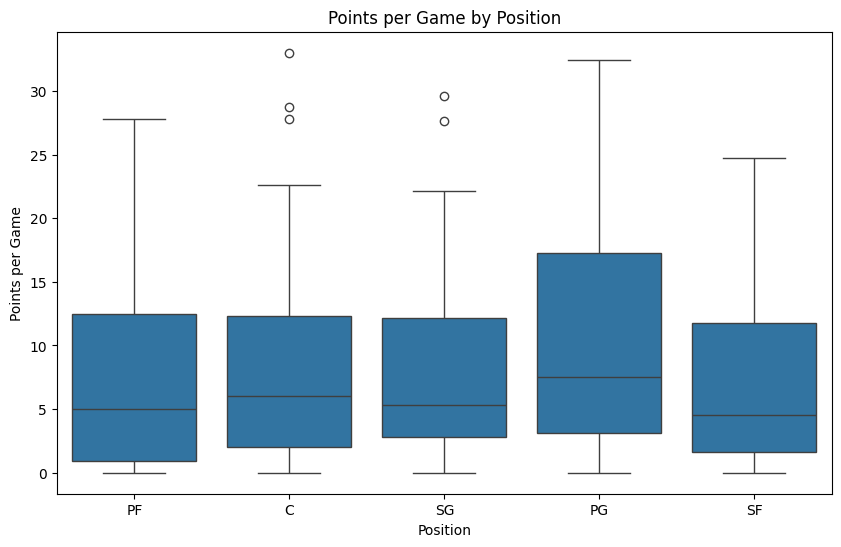

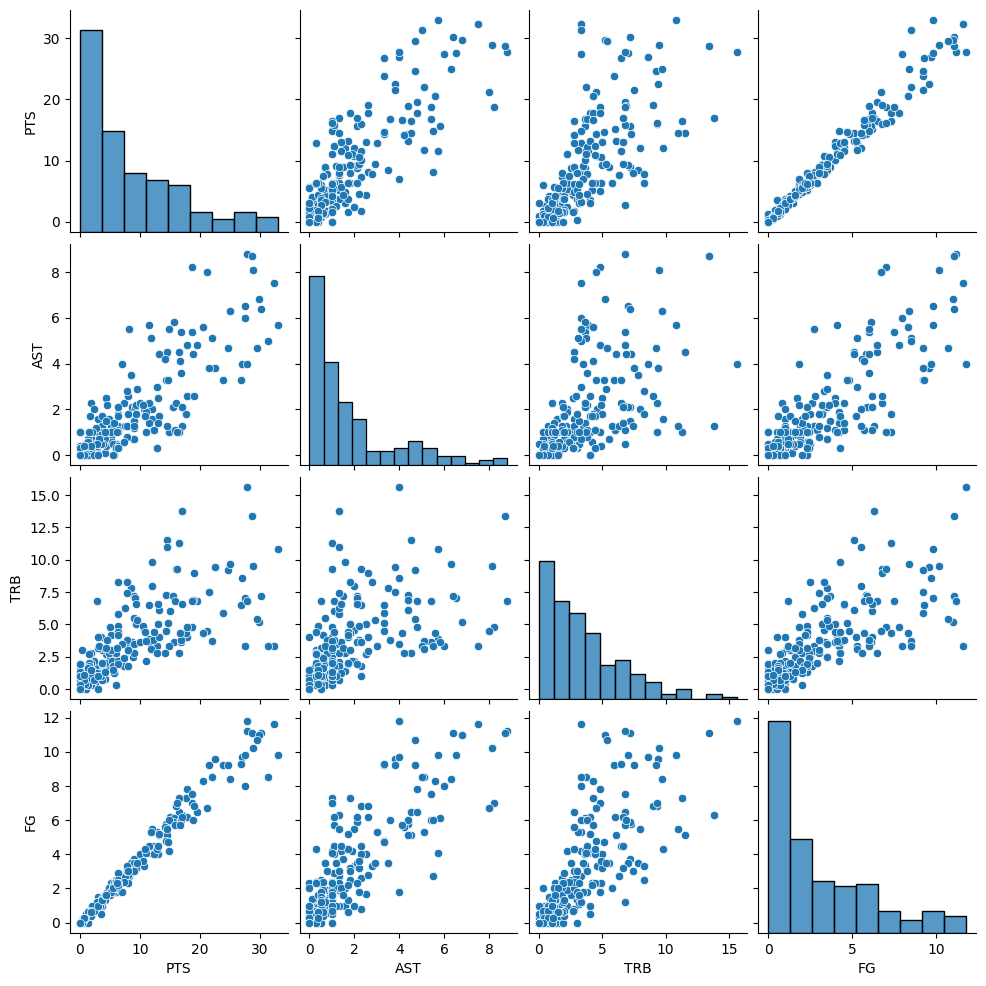

In [5]:
print(data.describe())

# Data Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['PTS'], bins=30, kde=True)
plt.title('Points per Game Distribution')
plt.xlabel('Points per Game')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for some key features (e.g., Points vs. Assists, Points vs. Rebounds)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PTS', y='AST', data=data)
plt.title('Points vs. Assists')
plt.xlabel('Points per Game')
plt.ylabel('Assists per Game')
plt.show()

# Correlation Matrix
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Boxplot for Outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pos', y='PTS', data=data)
plt.title('Points per Game by Position')
plt.xlabel('Position')
plt.ylabel('Points per Game')
plt.show()

# Pairplot of several features to look for relationships (e.g., PTS, AST, TRB, FG)
sns.pairplot(data[['PTS', 'AST', 'TRB', 'FG']])
plt.show()